# Neto customer churn predict project

## Summary

This is a data project to see if we can take customer data from the Neto platform and categorise and hopefully in the end "predict" when a customer is likely to churn. There will be a heap of assumptions which I will note in here.

### Research links

https://www.kaggle.com/pavanraj159/telecom-customer-churn-prediction/data

### Assumptions

- churn can be indicated by last login date of an account
- usage behaviour of a customers use of the export system could indicate signs of churn

### Data observation

`Neto License Registration Date` and `Go Live Date` are sometime entered "backwards" so when calulating the `go live days` I am taking the absolute value so I dont get a negative value.

`go live day` - if they are not `LIVE` I set the value to `-1` so we know its not live yet, 0 is a valid period of days.

`canceldate` - is not always in the future so I have had to get absolute values when calculating days active

## Pre Processing


In [212]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
import math

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
# Load in data

PATH = "../../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=["canceldate", "licence_registration_date", "golive_date"])

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [214]:
# Drop unwanted columns
df_raw = df_raw.drop(columns=['canceldate'])

In [215]:
# These steps can only be run once then you need to comment them out

#add_datepart(df_raw, 'canceldate')
add_datepart(df_raw, 'licence_registration_date')
add_datepart(df_raw, 'golive_date')

In [216]:
# Set default values for NaN values

df_raw.nps = df_raw.nps.fillna(np.nanmean(df_raw.nps))
df_raw.last_active_days = df_raw.last_active_days.fillna(np.mean(df_raw.last_active_days))
df_raw.churn_concern = df_raw.churn_concern.fillna(0)
train_cats(df_raw)

In [217]:
# Save the pre-processed data to disk
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/churn')

In [218]:
# Read in data from disk
df_raw = pd.read_feather('tmp/churn')

In [219]:
def split_vals(a,n): return a[:n], a[n:]

# Complete the transformation of all data into numbers using proc_df and create training dataframes
df_trn, y_trn, nas = proc_df(df_raw, 'churn_concern', max_n_cat=7)

#Drop unwanted columns
df_trn = df_trn.drop(columns=['licence_status_CANCELLED', 'churned', 'cancel_reason', 'cancel_details'])

n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [220]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [221]:
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [222]:
reset_rf_samples()

m = RandomForestRegressor(n_estimators=400, min_samples_leaf=1, max_features=int(math.log2(len(df_raw.columns))), n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.028114105073144935, 0.2178389600140434, 0.9967842861266808, 0.660500998025412, 0.9760523713923329]


In [223]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 126 ms, sys: 51.6 ms, total: 178 ms
Wall time: 361 ms


(0.98, 0.13999999999999999)

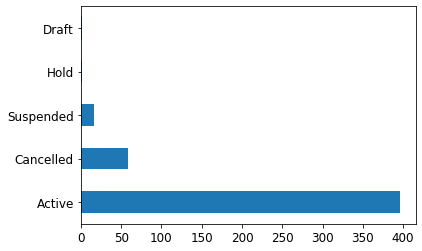

In [224]:
# This shows us a unique count of the column account_status
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.account_status.value_counts().plot.barh();

In [225]:
flds = ['days_active', 'churn_concern', 'pred', 'pred_std']
enc_summ = x[flds].groupby('days_active', as_index=False).mean()
enc_summ

,days_active,churn_concern,pred,pred_std
0,7,1.0,0.96750,0.177324
1,9,0.5,0.50750,0.390194
2,10,0.0,0.20250,0.401851
3,11,0.0,0.22250,0.415654
4,12,0.5,0.56500,0.342101
...,...,...,...,...
200,300,0.0,0.10000,0.300000
201,302,0.0,0.10750,0.309748
202,305,0.0,0.13125,0.333909
203,306,0.0,0.26250,0.439993


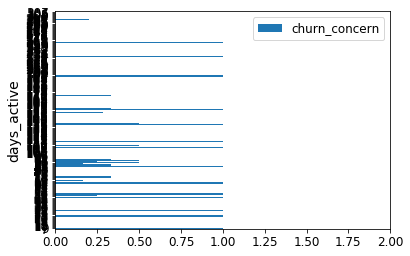

In [226]:
enc_summ = enc_summ[~pd.isnull(enc_summ.churn_concern)]
enc_summ.plot('days_active', 'churn_concern', 'barh', xlim=(0,2));

In [227]:
flds = ['account_status', 'churn_concern', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,churn_concern,pred,pred_std
account_status,,,
Active,0.020202,0.200246,0.393233
Cancelled,0.844828,0.841853,0.315741
Draft,1.000000,0.820000,0.384187
Hold,0.000000,0.415000,0.492722
Suspended,0.000000,0.294844,0.454895


In [228]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

account_status
Active       1.963749
Suspended    1.542833
Hold         1.187282
Draft        0.468521
Cancelled    0.375055
dtype: float64

In [229]:
fi = rf_feat_importance(m, df_trn); fi[:20]

,cols,imp
39,account_status_Active,0.214150
45,licence_status_LIVE,0.157032
3,last_active_days,0.142371
44,account_status_nan,0.128860
2,days_active,0.057557
51,changing_platform_nan,0.051166
7,plans,0.033468
8,plan,0.028728
40,account_status_Cancelled,0.021317
47,licence_status_STAGING,0.017337


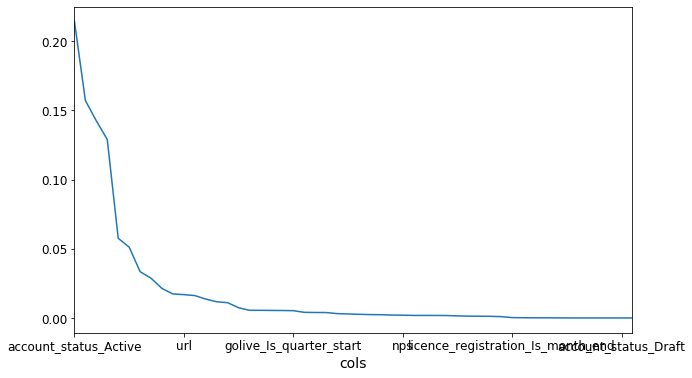

In [230]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [231]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

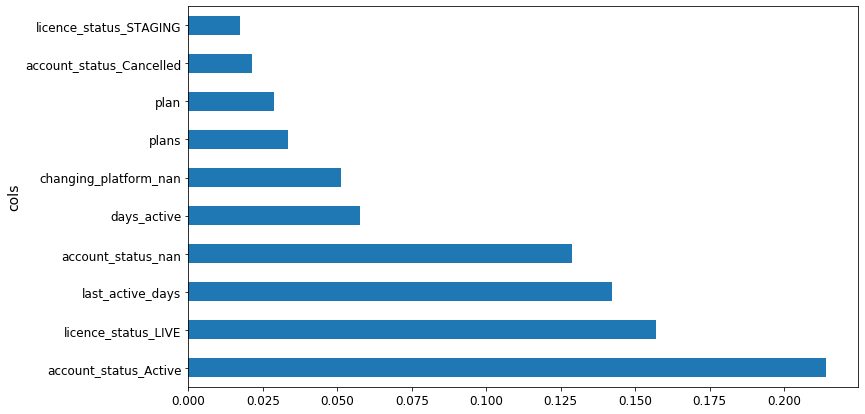

In [232]:
plot_fi(fi[:10]);

In [233]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

21

In [234]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [235]:
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.050372701698224706, 0.110376482268581, 0.9896766806811517, 0.9128393441078126, 0.9819163891222001]


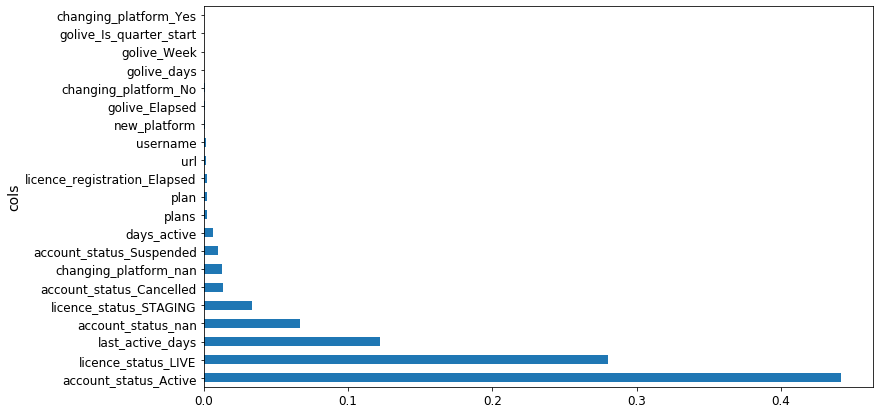

In [236]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [237]:
df_trn2, y_trn, nas = proc_df(df_raw, 'churn_concern', max_n_cat=5)
X_train, X_valid = split_vals(df_trn2, n_trn)

In [238]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.04308937192523859, 0.08063896579684011, 0.9924461353361657, 0.9534781163806093, 0.9869074386292845]


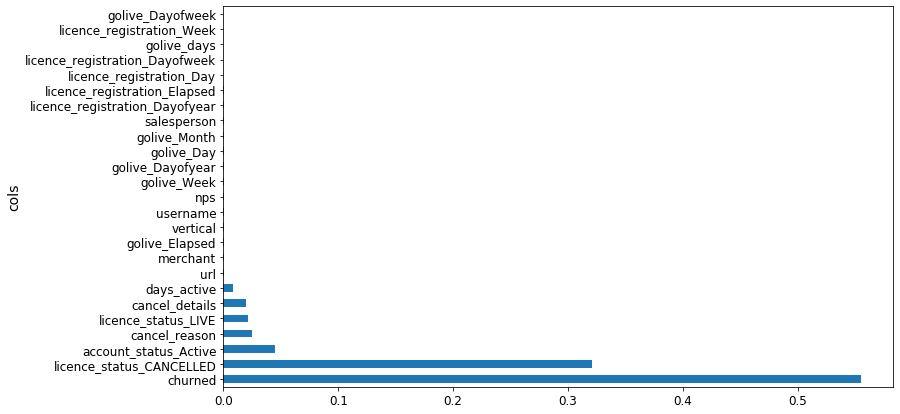

In [239]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

In [240]:
from scipy.cluster import hierarchy as hc

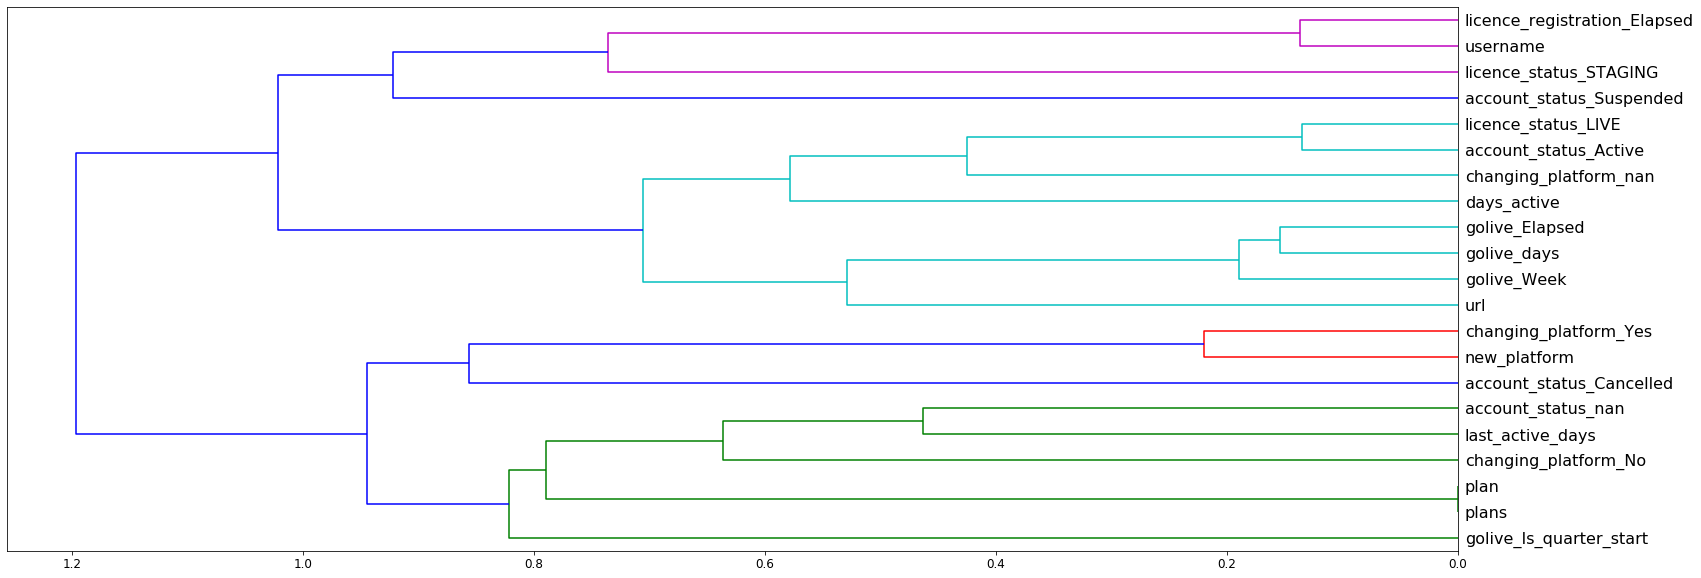

In [241]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 5)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(26,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [242]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [243]:
get_oob(df_keep)

0.9808842176413928

In [245]:
for c in ('username', 'licence_registration_Elapsed', 'licence_status_LIVE', 'account_status_Active', 'golive_Elapsed', 'golive_days', 'changing_platform_Yes', 'new_platform', 'plan', 'plans'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

username 0.9814688883965056
licence_registration_Elapsed 0.9799504258263789
licence_status_LIVE 0.9631746231424385
account_status_Active 0.9827393995811216
golive_Elapsed 0.980594809114286
golive_days 0.9817044269904217
changing_platform_Yes 0.9806120282077513
new_platform 0.9816902741880555
plan 0.9814940953772019
plans 0.9799705763937516


In [246]:
to_drop = ['licence_status_LIVE', 'plans', 'licence_registration_Elapsed']
get_oob(df_keep.drop(to_drop, axis=1))

0.9612307492187074

In [247]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [248]:
np.array(df_keep.columns)
keep_cols = np.array(df_keep.columns)
df_keep = df_trn[keep_cols]

In [249]:
reset_rf_samples()

In [260]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.04229948093929218, 0.08065626266465999, 0.9927205436144978, 0.9534581565717246, 0.986656657521222]


In [264]:
from pdpbox import pdp
from plotnine import *

df_trn2, y_trn, nas = proc_df(df_raw, 'churn_concern', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

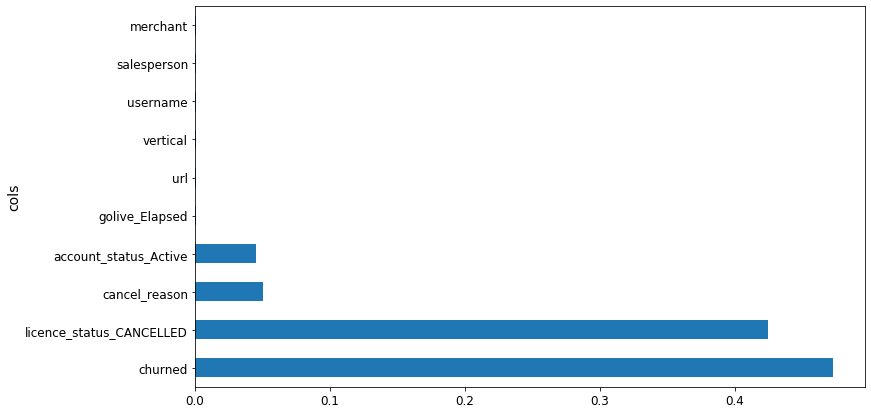

In [265]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

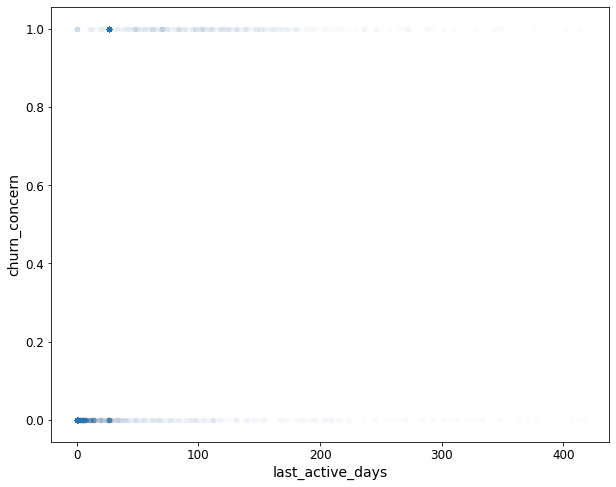

In [269]:
df_raw.plot('last_active_days', 'churn_concern', 'scatter', alpha=0.01, figsize=(10,8));

In [344]:
x_all = get_sample(df_raw[df_raw.last_active_days<200], 500)

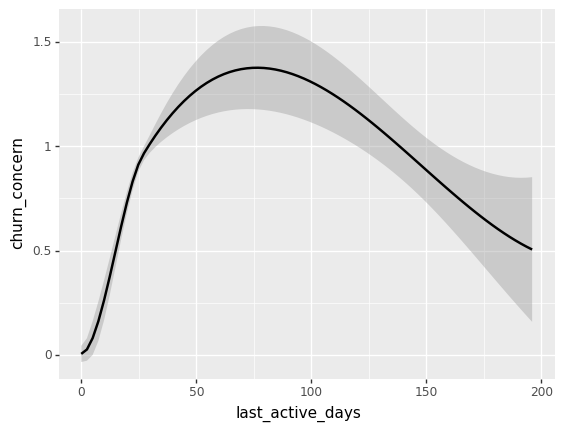

<ggplot: (-9223372029266095493)>

In [345]:
ggplot(x_all, aes('last_active_days', 'churn_concern'))+stat_smooth(se=True, method='loess')

In [346]:
def plot_pdp(feat, clusters = None, feat_name = None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature = feat, model_features = x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines = True,
                        cluster = clusters is not None,
                        n_cluster_centers = clusters)

In [347]:
x.columns

Index(['username', 'merchant', 'days_active', 'last_active_days', 'nps',
       'cancel_reason', 'cancel_details', 'team', 'vertical', 'plans', 'plan',
       'new_platform', 'salesperson', 'golive_days', 'url', 'churned',
       'licence_registration_Year', 'licence_registration_Month',
       'licence_registration_Week', 'licence_registration_Day',
       'licence_registration_Dayofweek', 'licence_registration_Dayofyear',
       'licence_registration_Is_month_end',
       'licence_registration_Is_month_start',
       'licence_registration_Is_quarter_end',
       'licence_registration_Is_quarter_start',
       'licence_registration_Is_year_end',
       'licence_registration_Is_year_start', 'licence_registration_Elapsed',
       'golive_Year', 'golive_Month', 'golive_Week', 'golive_Day',
       'golive_Dayofweek', 'golive_Dayofyear', 'golive_Is_month_end',
       'golive_Is_month_start', 'golive_Is_quarter_end',
       'golive_Is_quarter_start', 'golive_Is_year_end', 'golive_Is_year_st

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c460739b0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c46048e80>})

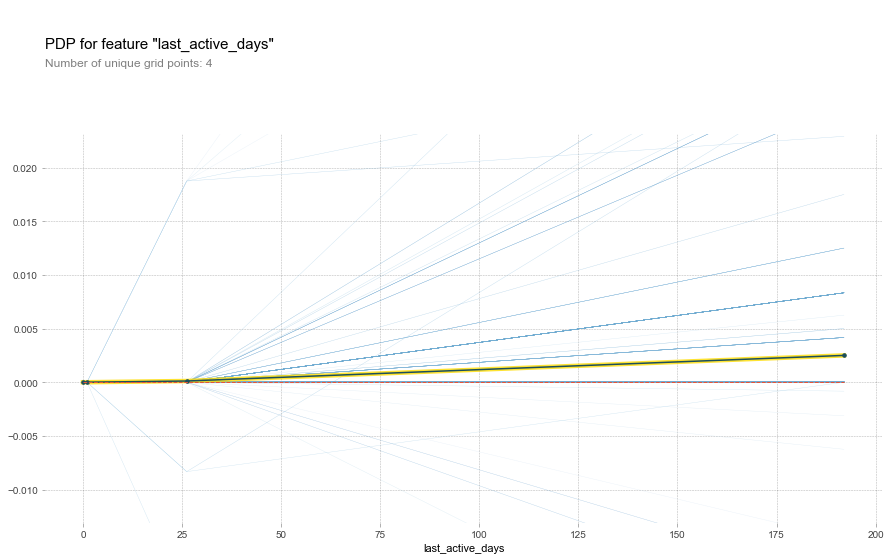

In [350]:
x = get_sample(X_train[X_train.last_active_days<200], 500)
plot_pdp('last_active_days')

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

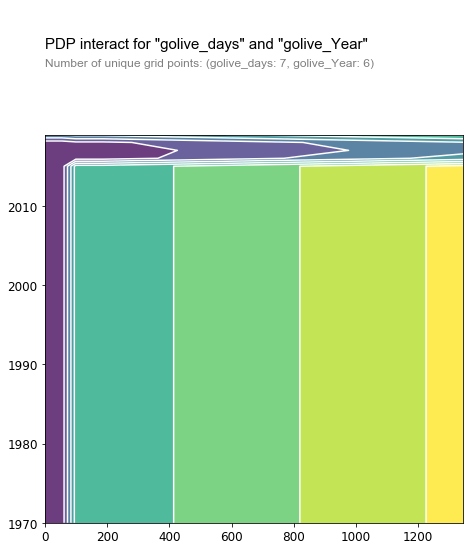

In [354]:
feats = ['golive_days', 'golive_Year']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c458ac668>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c46bc66a0>})

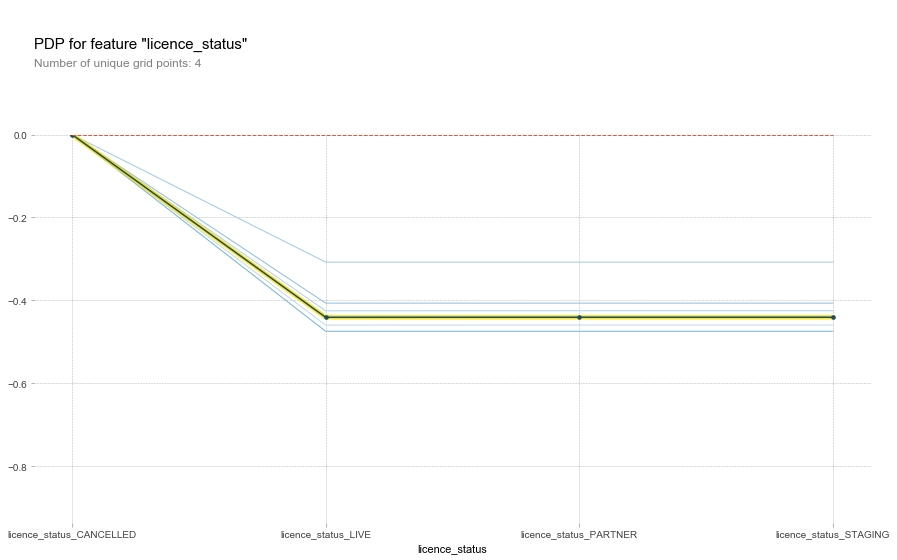

In [355]:
plot_pdp(['licence_status_CANCELLED', 'licence_status_LIVE', 'licence_status_PARTNER', 'licence_status_STAGING'], 5, 'licence_status')